In [1]:
import scipy.misc
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.optim as optim
import nyu_dataset
import pix2pixHD_model
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import nyu_dataset
import pix2pixHD_model
from torch.utils.data import DataLoader 
from sklearn.cluster import KMeans
import tqdm

/home/sasha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
segmentation_dataset_train = nyu_dataset.SegmentationDataset(
        transforms=nyu_dataset.SegmentationTransform(train_trainsforms=False, resize=False), 
        use_instance_segmentation=True)
data_loader_train = DataLoader(segmentation_dataset_train, batch_size=1, shuffle=True, num_workers=1)

In [3]:
encoder = pix2pixHD_model.FeatureEncoder(3, 3, instance_norm=True)

In [4]:
encoder.load_state_dict(torch.load('./encoder_150_0', map_location='cpu'))

In [5]:
class_features = {}

for image, segm, inst, bord in tqdm.tqdm(data_loader_train):
    image = Variable(image, requires_grad=False, volatile=True)
    segm = Variable(segm, requires_grad=False, volatile=True)
    
    encoded_features = encoder.forward(image, inst)
    
    segmentation = np.argmax(segm.data.numpy()[0], axis=0)
    instance_segmentation = inst.numpy()[0][0]
    
    features = encoded_features.data.numpy()[0]
    
    unique_instance_numbers = np.unique(instance_segmentation)
    
    for instance_number in unique_instance_numbers:
        instance_class = segmentation[instance_segmentation == instance_number][0]
        instance_feature = features[:, instance_segmentation == instance_number][:, 0]
        if instance_class in class_features:
            class_features[instance_class].append(instance_feature)
        else:
            class_features[instance_class] = [instance_feature]

100%|██████████| 1200/1200 [31:30<00:00,  1.58s/it]


In [7]:
clusters = {}
for current_class in class_features:
    clusters[current_class] = KMeans(n_clusters=10, 
                                     random_state=42).fit(np.array(class_features[current_class])).cluster_centers_

In [2]:
import pickle

In [10]:
with open('./features_dict', 'wb') as f:
        pickle.dump(clusters, f, pickle.HIGHEST_PROTOCOL)

In [3]:
with open('./features_dict', 'rb') as f:
    clusters = pickle.load(f)

In [4]:
segmentation_dataset_validation = nyu_dataset.SegmentationDataset(path_to_datafolder='./datasets/nyu/val/', 
        transforms=nyu_dataset.SegmentationTransform(train_trainsforms=False, resize=False), 
        use_instance_segmentation=True)
data_loader_val = DataLoader(segmentation_dataset_validation, batch_size=1, shuffle=False, num_workers=1)

In [5]:
collected_cluster = 0

In [6]:
generator = pix2pixHD_model.GlobalGenerator(41 + 3 + 1, 3, instance_norm=True)

In [7]:
generator.load_state_dict(torch.load('./generator_150_0', map_location='cpu'))

In [36]:
images = [3, 4, 17]

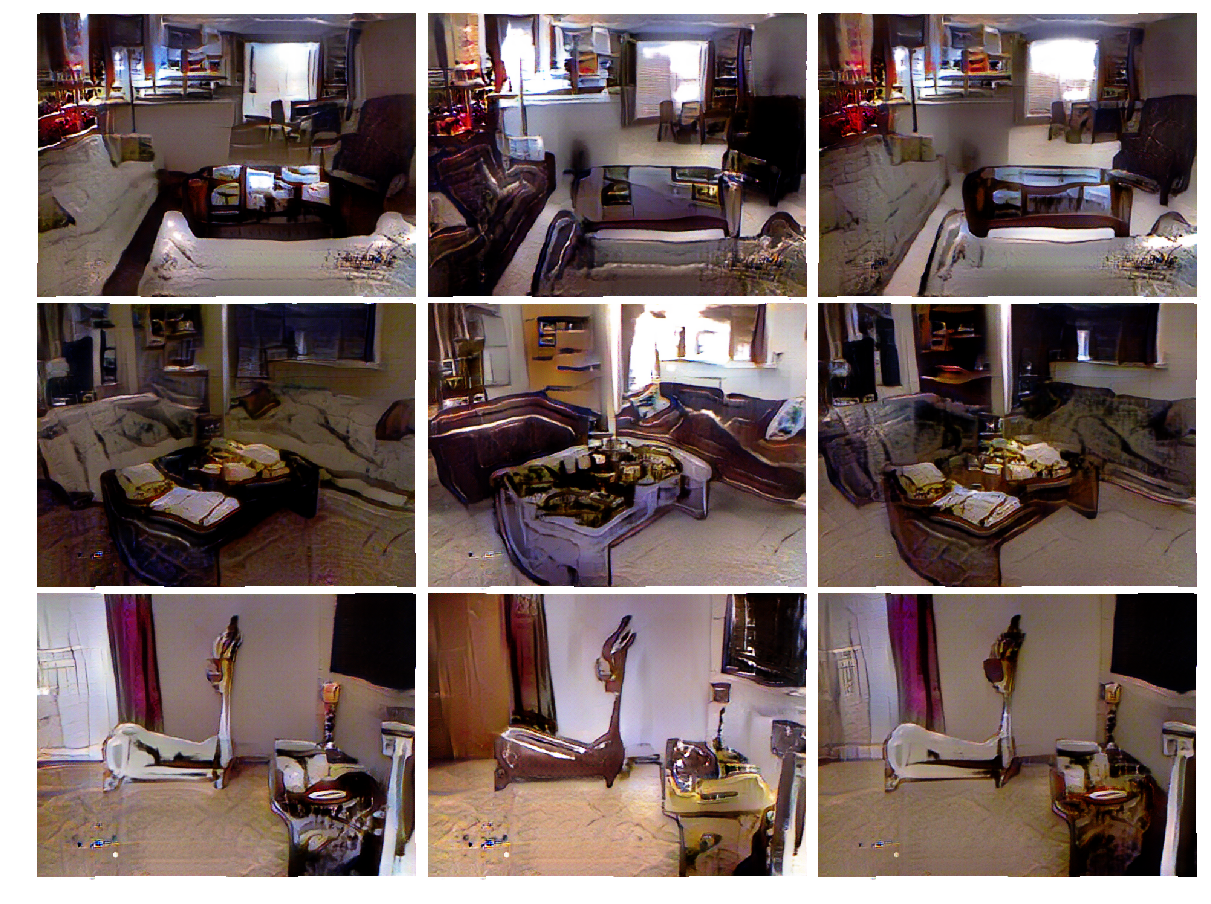

In [38]:
f, ax = plt.subplots(3, 3, figsize=(21,16))
f.subplots_adjust(wspace=0, hspace=0)
i = 0
j = 0

for image, segmentation, inst, borders  in data_loader_val: 
    if i in images:
        image = Variable(image, requires_grad=False, volatile=True)
        segmentation = Variable(segmentation, requires_grad=False, volatile=True)
        borders = Variable(borders, requires_grad=False, volatile=True)

        instance_segmentation = inst.numpy()[0][0]
        segmentation_numpy = np.argmax(segmentation.data.numpy()[0], axis=0)
        
        for k in range(3):
            encoded_val = np.zeros((1, 3, segmentation_numpy.shape[0], segmentation_numpy.shape[1]))

            unique_instance_numbers = np.unique(instance_segmentation)

            for instance_number in unique_instance_numbers:
                instance_class = segmentation_numpy[instance_segmentation == instance_number][0]
                encoded_val[0, :, instance_segmentation == instance_number] =\
                    clusters[instance_class][k].copy()
            encoded_val = Variable(torch.FloatTensor(encoded_val), requires_grad=False, volatile=True)
            input_generator = torch.cat((segmentation, encoded_val, borders), 1)
            generated_image = np.rollaxis((generator.forward(input_generator).data.numpy()[0] + 1)/2, 0, 3)

            ax[j, k].imshow(generated_image)
            ax[j, k].axis('off')
            
        j += 1
    i += 1
    if i > 17:
        break
    
plt.show()